# Heat illnesses during European and World Championships in Athletics

Notebook that visualises the number of various heat-related illnesses against different daily heat indices based on the Universal Thermal Climate Index (UTCI).


Ignore this:

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## 1. Load the data

In [2]:
# IMPORT PACKAGES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize

# read xlsx file
path = "/Users/milan/git/AthleticsChampionshipsHeat/data/"
DF = pd.read_excel(path+"IllnessesHeat_10Sep.xlsx")

# function to translate a column named by alphabet A,B,C,...AA,AB, etc into an index 1,2,3,...
def ABC2index(S):
    i=0
    for j,s in enumerate(list(S)):
        i += j*26+(ord(s)-65)
    
    return i

In [3]:
# LOAD HEAT ILLNESS DATA
di_heatcond = DF.values[:,ABC2index("AI")].astype(np.float)  # daily incidences of heat-related conditions
di_heatilln = DF.values[:,ABC2index("AN")].astype(np.float)  # di of heat illnesses
di_heatcond_illn = di_heatcond + di_heatilln                 # di of heat-related illnesses

In [6]:
# LOAD UTCI DATA
ndays = len(di_heatcond)
UTCImax = np.zeros((ndays,3))    # time x (expected, min, max)
UTCImaxs = np.zeros((ndays,5,5))
UTCImean = np.zeros((ndays,3))
UTCI3day = np.zeros((ndays,3))
UTCIdiff = np.zeros((ndays,3))

events = ["berlin2009","daegu2011","helsinki2012", "moscow2013","zuerich2014",
          "amsterdam2016","berlin2018"]
events_long = ["Berlin 2009","Daegu 2011","Helsinki 2012","Moscow 2013","Zürich 2014",
        "Amsterdam 2016", "Berlin 2018"]
nevents = len(events)
ndays_per_event = [0,]*nevents

i = 0
for ifile,file in enumerate(events):
    # expected
    ma = np.load(path+file+"utci_daily.npz")["UTCI_dailymax"]
    me = np.load(path+file+"utci_daily.npz")["UTCI_dailymean"]
    td = np.load(path+file+"utci_daily.npz")["UTCI_3daymean"]
    di = np.load(path+file+"utci_daily.npz")["UTCI_dailydiff"]
    
    n = len(ma)
    ndays_per_event[ifile] = n
    
    UTCImax[i:i+n,0] = ma
    UTCImean[i:i+n,0] = me
    UTCI3day[i:i+n,0] = td
    UTCIdiff[i:i+n,0] = di
    
    # all
    UTCImaxs[i:i+n,:,:] = np.load(path+file+"utci_daily_maxs.npz")["UTCI_dailymaxs"]
    
    # uncertainty - minimum
    ma = np.load(path+file+"utci_daily.npz")["UTCI_dailymax0"]
    me = np.load(path+file+"utci_daily.npz")["UTCI_dailymean0"]
    td = np.load(path+file+"utci_daily.npz")["UTCI_3daymean0"]
    di = np.load(path+file+"utci_daily.npz")["UTCI_dailydiff0"]
    
    UTCImax[i:i+n,1] = ma
    UTCImean[i:i+n,1] = me
    UTCI3day[i:i+n,1] = td
    UTCIdiff[i:i+n,1] = di
    
    # uncertainty - maximum
    ma = np.load(path+file+"utci_daily.npz")["UTCI_dailymax1"]
    me = np.load(path+file+"utci_daily.npz")["UTCI_dailymean1"]
    td = np.load(path+file+"utci_daily.npz")["UTCI_3daymean1"]
    di = np.load(path+file+"utci_daily.npz")["UTCI_dailydiff1"]
    
    UTCImax[i:i+n,2] = ma
    UTCImean[i:i+n,2] = me
    UTCI3day[i:i+n,2] = td
    UTCIdiff[i:i+n,2] = di
    
    i += n

nidxs = np.concatenate([[0],np.cumsum(ndays_per_event)])

# sea points are 1e20, mask out
UTCImaxs = np.ma.masked_array(UTCImaxs,mask=UTCImaxs == 1e20)

# 2. Linear/quadratic fit to data

1. Create UTCI bins, e.g. 4 or 5 ˚C
2. Sample randomly from the UTCI distribution for every event day (the uncertainty from location)
3. Put the data into the bins from 1.
4. Calculate the e.g. 10% risk of daily incidences
5. Statistically fit the 10% risk of daily incidences to bin-mids via linear/quadratic fit.
6. Repeat 1.-5. N times, as well as for the best-estimate (the central grid point, which is closest to the stadium).
7. Plot the best-estimate fit, as well as the 5-95% range of N fits.

In [7]:
# heat illness risk model, lin/quad with constraint that vertex has to be on x-axis.
def risk_lin(x,a,T0):
    return a*(x-T0)

def risk_quad(x,a,T0):
    return a*(x-T0)**2

# residual functions for least squares estimation
def residual_lin(p,x,y):
    return y-risk_lin(x,*p)

def residual_quad(p,x,y):
    return y-risk_quad(x,*p)

In [24]:
# least squares estimation
prisks = [10,50,"mean"]                # risk [%] of daily incidence considered
xall = np.linspace(10,40,100)   # evaluate models on these points

# uncertainty
p0 = [0.,15.]
mcn = 1000   # number of monte carlo draws
fits0 = np.empty((len(xall),mcn,len(prisks)))     # heat-related conditions
fits1 = np.empty((len(xall),mcn,len(prisks)))     # heat illnesses
fits2 = np.empty((len(xall),mcn,len(prisks)))     # heat-related illnesses

slopes = np.empty((mcn,len(prisks),3 ))               

for ip,prisk in enumerate(prisks):       # loop over different risk levels
    for n in range(mcn):                 # monte carlo mcn times
        UTCIrand = np.empty(ndays)       # pick random UTCI from grid points for each event day
        for ii in range(ndays):
            xy = np.random.randint(0,25)
            while UTCImaxs[ii,:,:].flatten().mask[xy]: # check that we don't pick a masked sea-point
                xy = np.random.randint(0,25)           # if masked, pull another random grid point

            UTCIrand[ii] = UTCImaxs[ii,:,:].flatten().data[xy]

        # pick bins based on sorting the temperatures
        npoints = np.random.randint(5,11)    # reasonable binsizes
        bins = np.sort(UTCIrand)[::npoints]
        bins[-1] = np.max(UTCIrand)          # extend last bin to be inclusive with max
        nbins = len(bins)-1                  # number of bins
        binmids = np.empty(nbins)    # bin centres

        diheatc = np.empty(nbins)     # daily incidence per bin at prisk risk level
        diheati = np.empty(nbins)     # for illnesses too
        diheatci = np.empty(nbins)       # for all illnesses

        for i in range(nbins):
            which_utcis = np.logical_and(UTCIrand > bins[i],UTCIrand <= bins[i+1])
            ninbins = np.sum(which_utcis)
            
            # incidence rates have a 2std of +-1 error
            diheatc_in_bin = di_heatcond[which_utcis] + 0.5*np.random.randn(ninbins)
            diheati_in_bin = di_heatilln[which_utcis] + 0.5*np.random.randn(ninbins)
            diheatci_in_bin = di_heatcond_illn[which_utcis] + 0.5*np.random.randn(ninbins)
            
            # clip distributions at 0
            diheatc_in_bin = np.maximum(diheatc_in_bin,0)
            diheati_in_bin = np.maximum(diheati_in_bin,0)
            diheatci_in_bin = np.maximum(diheatci_in_bin,0)
            
            binmids[i] = np.mean(UTCIrand[which_utcis])
            
            if np.sum(which_utcis) == 0:
                print(prisk,n,i,diheat_in_bin)
            
            if prisk == "mean":
                diheatc[i] = np.mean(diheatc_in_bin)
                diheati[i] = np.mean(diheati_in_bin)
                diheatci[i] = np.mean(diheatci_in_bin)
            else:
                diheatc[i] = np.percentile(diheatc_in_bin,100-prisk)
                diheati[i] = np.percentile(diheati_in_bin,100-prisk)
                diheatci[i] = np.percentile(diheatci_in_bin,100-prisk)

        # use either linear or quadratic model here
        p0est = optimize.leastsq(residual_lin, p0, args=(binmids, diheatci))[0]      # both heat-related conditions and illnesses
        p1est = optimize.leastsq(residual_lin, p0, args=(binmids, diheatc))[0]       # heat-related conditions
        p2est = optimize.leastsq(residual_lin, p0, args=(binmids, diheati))[0]       # heat illnesses
        
        slopes[n,ip,:] = [p0est[0],p1est[0],p2est[0]]
        
        fits0[:,n,ip] = risk_lin(xall,*p0est)
        fits1[:,n,ip] = risk_lin(xall,*p1est)
        fits2[:,n,ip] = risk_lin(xall,*p2est)


/Users/milan/miniconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


In [12]:
pestd = optimize.leastsq(residual_lin, p0, args=(UTCImax[:,0],di_heatcond))[0]
fitd = risk_lin(xall,*pestd)

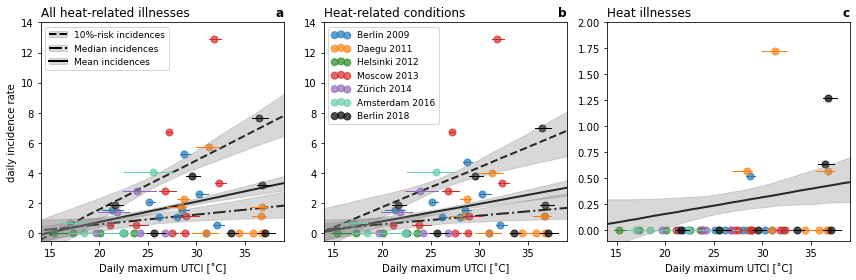

In [22]:
# PLOTTING WHAT's INTERESTING
colours = ["C0","C1","forestgreen","C3","C4","mediumaquamarine","k"]

fig,axs = plt.subplots(1,3,sharex=True,figsize=(12,4))
alfa=0.7
alfa2=0.3
lws=1.0
pci = [2.5,97.5]

# scatterpoints for expected
for i in range(nevents):
    j0,j1 = nidxs[i],nidxs[i+1]
    axs[0].scatter(UTCImax[j0:j1,0],di_heatcond_illn[j0:j1],50,color=colours[i],alpha=alfa,label=events_long[i])
    axs[1].scatter(UTCImax[j0:j1,0],di_heatcond[j0:j1],50,color=colours[i],alpha=alfa,label=events_long[i])
    axs[2].scatter(UTCImax[j0:j1,0],di_heatilln[j0:j1],50,color=colours[i],alpha=alfa,label=events_long[i])
    
# lines for uncertainty
for i in range(nevents):
    j0,j1 = nidxs[i],nidxs[i+1]
    axs[0].plot(UTCImax[j0:j1,1:].T,np.array([di_heatcond_illn[j0:j1]]*2),colours[i],lw=lws)
    axs[1].plot(UTCImax[j0:j1,1:].T,np.array([di_heatcond[j0:j1]]*2),colours[i],lw=lws)
    axs[2].plot(UTCImax[j0:j1,1:].T,np.array([di_heatilln[j0:j1]]*2),colours[i],lw=lws)
    
# curve fitting
fb01 = axs[0].fill_between(xall,np.percentile(fits0[:,:,0],pci[0],axis=1),np.percentile(fits0[:,:,0],pci[1],axis=1),color="grey",alpha=alfa2)
fb02 = axs[0].fill_between(xall,np.percentile(fits0[:,:,1],pci[0],axis=1),np.percentile(fits0[:,:,1],pci[1],axis=1),color="grey",alpha=alfa2)
fb03 = axs[0].fill_between(xall,np.percentile(fits0[:,:,2],pci[0],axis=1),np.percentile(fits0[:,:,2],pci[1],axis=1),color="grey",alpha=alfa2)

axs[1].fill_between(xall,np.percentile(fits1[:,:,0],pci[0],axis=1),np.percentile(fits1[:,:,0],pci[1],axis=1),color="grey",alpha=alfa2)
axs[1].fill_between(xall,np.percentile(fits1[:,:,1],pci[0],axis=1),np.percentile(fits1[:,:,1],pci[1],axis=1),color="grey",alpha=alfa2)
axs[1].fill_between(xall,np.percentile(fits1[:,:,2],pci[0],axis=1),np.percentile(fits1[:,:,2],pci[1],axis=1),color="grey",alpha=alfa2)

axs[2].fill_between(xall,np.percentile(fits2[:,:,2],pci[0],axis=1),np.percentile(fits2[:,:,2],pci[1],axis=1),color="grey",alpha=alfa2)

h01, = axs[0].plot(xall,np.median(fits0[:,:,0],axis=1),"k--",lw=2,zorder=-5)
h02, = axs[0].plot(xall,np.median(fits0[:,:,1],axis=1),"k-.",lw=2,zorder=-5)
h03, = axs[0].plot(xall,np.median(fits0[:,:,2],axis=1),"k",lw=2,zorder=-5)

axs[1].plot(xall,np.median(fits1[:,:,0],axis=1),"k--",lw=2,zorder=-5)
axs[1].plot(xall,np.median(fits1[:,:,1],axis=1),"k-.",lw=2,zorder=-5)
axs[1].plot(xall,np.median(fits1[:,:,2],axis=1),"k",lw=2,zorder=-5)

axs[2].plot(xall,np.median(fits2[:,:,2],axis=1),"k",lw=2,zorder=-5)

axs[0].legend([(fb01,h01),(fb02,h02),(fb03,h03)],(str(prisks[0])+"%-risk incidences","Median incidences","Mean incidences"),loc=2,fontsize=9)

axs[0].set_title("All heat-related illnesses",loc="left")
axs[1].set_title("Heat-related conditions",loc="left")
axs[2].set_title("Heat illnesses",loc="left")

axs[0].set_title("a",loc="right",fontweight="bold")
axs[1].set_title("b",loc="right",fontweight="bold")
axs[2].set_title("c",loc="right",fontweight="bold")

axs[0].set_xlabel("Daily maximum UTCI [˚C]")
axs[1].set_xlabel("Daily maximum UTCI [˚C]")
axs[2].set_xlabel("Daily maximum UTCI [˚C]")

axs[0].set_ylabel("daily incidence rate")

axs[1].legend(loc=2,ncol=1,fontsize=9,scatterpoints=3)

axs[0].set_xlim(14,39)
axs[0].set_ylim(-0.5,14)
axs[1].set_ylim(-0.5,14)
axs[2].set_ylim(-0.1,2)
plt.tight_layout()

plt.show()

In [39]:
# mean incidences mean slope with 95%CI
mslope = [np.mean(slopes[:,2,0]),np.percentile(slopes[:,2,0],2.5),np.percentile(slopes[:,2,0],97.5)]
print("All heat-related illnesses")
print("Slope for mean incidences: {:.2f}±{:.2f} incidence rate/˚C".format(mslope[0],((mslope[2]-mslope[0])+(mslope[0]-mslope[1]))/2))

All heat-related illnesses
Slope for mean incidences: 0.14±0.04 incidence rate/˚C


In [44]:
# mean incidences mean slope with 95%CI
mslope = [np.mean(slopes[:,1,0]),np.percentile(slopes[:,1,0],2.5),np.percentile(slopes[:,1,0],97.5)]
print("All heat-related illnesses")
print("Slope for median incidences: {:.2f}±{:.2f} incidence rate/˚C".format(mslope[0],((mslope[2]-mslope[0])+(mslope[0]-mslope[1]))/2))

All heat-related illnesses
Slope for median incidences: 0.07±0.06 incidence rate/˚C


In [42]:
# 10%risk incidences mean slope with 95%CI
mslope = [np.mean(slopes[:,0,0]),np.percentile(slopes[:,0,0],2.5),np.percentile(slopes[:,0,0],97.5)]
print("All heat-related illnesses")
print("Slope for 10%-risk incidences: {:.2f}±{:.2f} incidence rate/˚C".format(mslope[0],((mslope[2]-mslope[0])+(mslope[0]-mslope[1]))/2))

All heat-related illnesses
Slope for 10%-risk incidences: 0.33±0.10 incidence rate/˚C


In [40]:
# mean incidences mean slope with 95%CI
mslope = [np.mean(slopes[:,2,1]),np.percentile(slopes[:,2,1],2.5),np.percentile(slopes[:,2,1],97.5)]
print("Heat-related conditions")
print("Slope for mean incidences: {:.2f}±{:.2f} incidence rate/˚C".format(mslope[0],((mslope[2]-mslope[0])+(mslope[0]-mslope[1]))/2))

Heat-related conditions
Slope for mean incidences: 0.12±0.04 incidence rate/˚C


In [45]:
# mean incidences mean slope with 95%CI
mslope = [np.mean(slopes[:,1,1]),np.percentile(slopes[:,1,1],2.5),np.percentile(slopes[:,1,1],97.5)]
print("Heat-related conditions")
print("Slope for median incidences: {:.2f}±{:.2f} incidence rate/˚C".format(mslope[0],((mslope[2]-mslope[0])+(mslope[0]-mslope[1]))/2))

Heat-related conditions
Slope for median incidences: 0.06±0.05 incidence rate/˚C


In [43]:
# 10%risk incidences mean slope with 95%CI
mslope = [np.mean(slopes[:,0,1]),np.percentile(slopes[:,0,1],2.5),np.percentile(slopes[:,0,1],97.5)]
print("Heat-related conditions")
print("Slope for 10%-risk incidences: {:.2f}±{:.2f} incidence rate/˚C".format(mslope[0],((mslope[2]-mslope[0])+(mslope[0]-mslope[1]))/2))

Heat-related conditions
Slope for 10%-risk incidences: 0.26±0.10 incidence rate/˚C


In [41]:
# mean incidences mean slope with 95%CI
mslope = [np.mean(slopes[:,2,2]),np.percentile(slopes[:,2,2],2.5),np.percentile(slopes[:,2,2],97.5)]
print("Heat illnesses")
print("Slope for mean incidences: {:.2f}±{:.2f} incidence rate/˚C".format(mslope[0],((mslope[2]-mslope[0])+(mslope[0]-mslope[1]))/2))

Heat illnesses
Slope for mean incidences: 0.02±0.02 incidence rate/˚C
